# Learning MPC for Piecewise Affine Systems

This notebook explains how the Learning MPC framework can be used to reduce the computational burden of optimal control for Piecewise Affine Systems. Recall that the receeding horizon optimal control for PWA systems is a mixed integer program due to the dependence of the dynamics on the state.

$$\min_{u_0,u_1,\dots} \sum_{k=0}^\infty x_k^\top Q x_k + u_k^\top R u_k$$

$$\text{s.t. } x_{k+1}=A_ix_k +B_iu_k +\mu_i \text{ if }x_k\in\mathcal{R}_i$$

$$x_k\in\mathcal{X},u_k\in\mathcal{U},k=0,1,...$$

In particular the complexity grows with the total number of distinct regions, and since the trajectories and the dynamics of those trajectories are coupled, there is not natural parallelism to exploit.

In [3]:
import numpy as np 
import polytope
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
sys.path.append('../src/fnc')

import lmpc_main as lmpc

import pwa_cluster as pwa


import UtilityFunc as util #BuildMatEqConstimport DefSystem, DefineRegions, PlotRegions, CurrentRegion, SysEvolution, \
    #BuildMatIneqConst, GetPred, BuildMatCost, BuildMatEqConst
    
% matplotlib inline
%load_ext autoreload
%autoreload 2

## Piecewise Affine Systems

A piecewise affine system has dynamics
$$ x_{k+1} = A_i x_k + B_i u_k + \mu_i, \text{  if  } x_k \in \mathcal{R}_i$$
where the $\mathcal{R}_i$ are convex regions that partition the state space. In this example, we consider double integrators with different parameters in three different regions.

A for region 0 is
 [[ 0.8  0.1]
 [ 0.   0.8]]
A for region 1 is
 [[ 0.85  0.15]
 [ 0.    0.85]]
A for region 2 is
 [[ 0.9  0.2]
 [ 0.   0.9]]


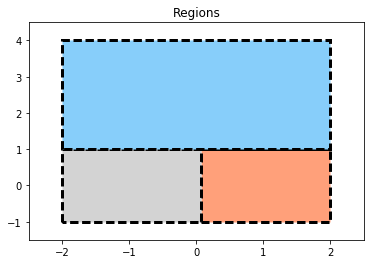

In [4]:
[A, B, Q, R, Q_LMPC, R_LMPC, _, Box_Points, _] = util.DefSystem(np)
p_region = []
F_region = []; b_region = [];

region_colors = ['lightsalmon', 'lightgray', 'lightskyblue']
plt.figure(); ax = plt.subplot(111); plt.title("Regions")
for k,box in enumerate(Box_Points):
    p = polytope.box2poly(box) #Polytope(vertices=Vertex)
    p.plot(ax, color=region_colors[k], alpha=1);
    ax.set_xlim([-2.5,2.5]); ax.set_ylim([-1.5, 4.5])
    p_region.append(p)
    F_region.append(p.A); b_region.append(p.b)
    print("A for region", k, "is\n", A[k])
    


## Construction of Safe Set

Recall that LMPC relies on the existence of a safe set of previously visited states. Next, we will use a hand designed controller to create the first trajectory.

(-1.5, 4.5)

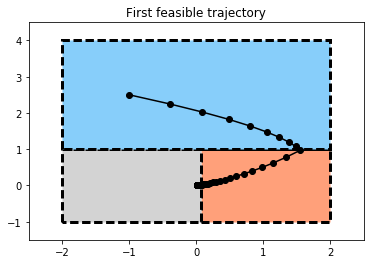

In [5]:
Time = 50                            # Number of simulation's time steps for first feasible trajectory
n,d = B[0].shape
x_feasible = np.zeros((n,Time+1))    # Initialize the closed loop trajectory
u_feasible = np.zeros((d,Time))      # Initialize the closed loop input

x_feasible[:,0] = np.array([-1, 2.5])
K = np.array([0.4221,  1.2439])

for i in range(0, Time):
    u_feasible[:,i] = -0*np.dot(K, x_feasible[:,i])
    x_feasible[:,i+1] = util.SysEvolution(x_feasible[:,i], u_feasible[:,i], F_region, b_region, np, \
                                          util.CurrentRegion, A, B)

plt.figure(); ax = plt.subplot(111); plt.title("First feasible trajectory")
for k,p in enumerate(p_region):
    p.plot(ax, color=region_colors[k], alpha=1);
plt.plot(x_feasible[0,:], x_feasible[1,:], '-o', color='black')
ax.set_xlim([-2.5,2.5]); ax.set_ylim([-1.5, 4.5])



## LMPC for Piecewise Affine Dynamics
Recall that in LMPC, the previous set of trajectories is used to construct the "safe set" $\mathcal{SS}$ which acts as the terminal constraint to ensure recursive feasibility. In the piecewise affine setting, we will split the safe set into pieces based on the regions, $\mathcal{SS}_i$. We will further use the safe set of previous trajectories to construct a switching signal $\gamma$, which fixes the dynamics and the transitions between different regions $\mathcal{R}_i$. 

$$
    \min_{u_0,u_1,\dots,u_{T-1}} \sum_{k=0}^{T-1} x_k^\top Q x_k + u_k^\top R u_k+x_T^\top Qx_T$$
   $$ \text{s.t.  } x_{k+1}=A_{\gamma(k)}x_k +B_{\gamma(k)}u_k +\mu_{\gamma(k)},x_k\in\mathcal{X}\cap\mathcal{R}_{\gamma(k)} $$
   $$ u_k\in\mathcal{U},x_T\in\mathcal{SS}_{\gamma(T)},k=0,1,...,T
$$

Once the switching signal is fixed, the optimization problem is a QP except for the integer terminal constraint. However, the search over terminal constraints is trivially parallelizable, and furthermore, a smaller subset of the safe set can be used while maintaining feasibility guarantees. A key question then is the definition of $\gamma$.

The switching sequence $\gamma$ is defined by a $T$-step
*candidate trajectory* $\mathbf{c}$ which is computed before each timestep. It is also a function of the selected terminal point $x_T^{j}$ from the $j$th learning iteration. Particularly, if the final point of $\mathbf{c}$ and terminal point $x_T^{j}$ coincide, then the states in $\mathbf{c}$ determine the switching sequence. Otherwise, the states of the safe set in the trajectory leading up to $x^j_T$ are used to define the switching sequence.

$$ \gamma(k) = \begin{cases} i\text{ : } \mathbf{c}_k\in\mathcal{R}_i \text{ if }\mathbf{c}_T = x^j_T \\
i\text{ : } x_k^{j}\in\mathcal{R}_i \text{ else }\end{cases} $$

Before each timestep, the candidate trajectory is synthesized as the predicted open loop trajectory of the previous timestep propagated one step forward in time.

In short, this formulation allows for the switching sequence to be defined only as a function of the terminal state, which means that the optimization problem can be solved as a series of QPs in parallel. The formulation is also flexible through the incorporation of $\mathbf{c}$ to learn to visit regions in a different sequence than in the original safe trajectory.


In [6]:
x, Steps = lmpc.runall_LMPC(A, B, F_region, b_region,  x_feasible, u_feasible, Q, R, Q_LMPC, R_LMPC)

====================================== STARTING LMPC OPTIMIZATION ===============================================
Feasible Iteration: 0, Time Steps 50.0, Iteration Cost: 48.21838
Learning Iteration: 1, Time Steps 30.0, Iteration Cost: 28.56756, Cost Improvement: 19.6508148, Iteration time: 0.780s, Average MIQP solver time: 0.026s
Learning Iteration: 2, Time Steps 29.0, Iteration Cost: 22.04792, Cost Improvement: 6.5196402, Iteration time: 0.668s, Average MIQP solver time: 0.023s
Learning Iteration: 3, Time Steps 29.0, Iteration Cost: 19.44989, Cost Improvement: 2.5980285, Iteration time: 0.733s, Average MIQP solver time: 0.025s
Learning Iteration: 4, Time Steps 29.0, Iteration Cost: 18.40516, Cost Improvement: 1.0447361, Iteration time: 0.659s, Average MIQP solver time: 0.023s
Learning Iteration: 5, Time Steps 29.0, Iteration Cost: 17.74465, Cost Improvement: 0.6605054, Iteration time: 0.717s, Average MIQP solver time: 0.025s
Learning Iteration: 6, Time Steps 29.0, Iteration Cost: 17.3

(-1.5, 4.5)

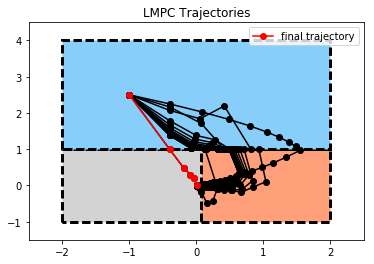

In [8]:
plt.figure(); ax = plt.subplot(111); plt.title("LMPC Trajectories")
for k,p in enumerate(p_region):
    p.plot(ax, color=region_colors[k], alpha=1);
for it in range(Steps.size-1):
    plt.plot(x[0,:Steps[it]+1,it], x[1,:Steps[it]+1,it], '-o', color='black')

plt.plot(x[0,:Steps[-1]+1,it], x[1,:Steps[-1]+1,it], '-o', color='red', label='final trajectory')
plt.legend()

ax.set_xlim([-2.5,2.5]); ax.set_ylim([-1.5, 4.5])